In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore")


In [ ]:
car_data_transformed = pd.read_csv('./Dane/car_data_transformed.csv')
recruitment_data_transformed = pd.read_csv('./Dane/recruitment_data_transformed.csv')
diabetes_data_transformed = pd.read_csv('./Dane/diabetes_data_transformed.csv')
banknote_authentication_transformed = pd.read_csv('./Dane/banknote_authentication_transformed.csv')
datasets = [car_data_transformed, recruitment_data_transformed, diabetes_data_transformed, banknote_authentication_transformed]

__TMACZASOWY KOD DO POPRAWY!!!!__

In [ ]:
datasets[3]['Target'] = datasets[3]['Target'] -1

In [ ]:
model_pipeline = Pipeline([
                         ('model', XGBClassifier(verbosity=0))])

In [ ]:
xgb = XGBClassifier(verbosity=0)
#see what default parameters are
print(xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


## RANDOM SEARCH

In [ ]:
param_grid = {
    'model__booster': ['gbtree', 'gblinear', 'dart'],
    'model__eta' :np.logspace(-6,0),
    'model__gamma': np.logspace(-6,3),
    'model__max_depth' : [ x for x in range(1,16,1)],
    'model__min_child_weight' : [ x for x in range(1,20) ],
    'model__subsample' : np.linspace(0,1),
    'model__colsample_bytree' : np.linspace(0,1),
    'model__sampling_method' : ['uniform', #'gradient_based'
                                ],
    'model__lambda' : np.logspace(-6,3),
    'model__alpha' : np.logspace(-6,3)
}

In [ ]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV

class CustomRandomizedSearchCV(RandomizedSearchCV):
    def __init__(self, estimator, param_distributions, n_iter=10, cv=None,
                 refit=True, n_jobs=None, verbose=0, pre_dispatch='2*n_jobs',
                 random_state=None, error_score='raise', return_train_score=False,
                 dataset_name=None, scoring = 'roc_auc'):
        # Explicitly calling the parent class constructor with named parameters
        super().__init__(estimator=estimator,
                         param_distributions=param_distributions,
                         n_iter=n_iter,
                         cv=cv,
                         refit=refit,
                         n_jobs=n_jobs,
                         verbose=verbose,
                         pre_dispatch=pre_dispatch,
                         random_state=random_state,
                         error_score=error_score,
                         return_train_score=return_train_score)

        self.dataset_name = dataset_name
        self.results_df = pd.DataFrame()

    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)

        # Collect results for each iteration
        results = []
        for idx, params in enumerate(self.cv_results_['params']):
            score = self.cv_results_['mean_test_score'][idx]
            params['Combination_ID'] = idx + 1
            params['Score'] = score
            params['Dataset'] = self.dataset_name
            results.append(params)

        # Create a DataFrame from the results
        self.results_df = pd.DataFrame(results)

        return self


In [ ]:
rs = CustomRandomizedSearchCV(model_pipeline,
                        param_grid,
                        cv = 3,
                        n_jobs = -1,
                        n_iter=300,
                        random_state=42
                        )

### CARS

In [ ]:
rs.fit(datasets[0].drop('Target', axis=1), datasets[0]['Target'])

CustomRandomizedSearchCV(cv=3,
                         estimator=Pipeline(steps=[('model',
                                                    XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  feature_types=None,
                                                                  gamma=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
                         random_state=42, scoring=None)

In [ ]:
best_params_0 = pd.DataFrame(rs.best_params_, index=[0])
results_0 = rs.results_df
results_0.to_csv('./Results/XGBOOST/results_0.csv', index=False)

In [ ]:
print(rs.best_params_)
print(rs.best_score_)
print(rs.best_estimator_)

{'model__subsample': 0.9183673469387754, 'model__sampling_method': 'uniform', 'model__min_child_weight': 12, 'model__max_depth': 11, 'model__lambda': 0.0013257113655901094, 'model__gamma': 1e-06, 'model__eta': 0.019306977288832496, 'model__colsample_bytree': 0.8979591836734693, 'model__booster': 'gbtree', 'model__alpha': 0.00010481131341546864, 'Combination_ID': 37, 'Score': 0.9070028111944279, 'Dataset': None}
0.9070028111944279
Pipeline(steps=[('model',
                 XGBClassifier(alpha=0.00010481131341546864, base_score=None,
                               booster='gbtree', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8979591836734693, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eta=0.019306977288832496, eval_metric=None,
                               feature_types=No

### RECRUITMENT

In [ ]:
rs.fit(datasets[1].drop('Target', axis=1), datasets[1]['Target'])

CustomRandomizedSearchCV(cv=3,
                         estimator=Pipeline(steps=[('model',
                                                    XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  feature_types=None,
                                                                  gamma=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
                         random_state=42, scoring=None)

In [ ]:
results_1 = rs.results_df
results_1.to_csv('./Results/XGBOOST/results_1.csv', index=False)

In [ ]:
print(rs.best_params_)
print(rs.best_score_)
print(rs.best_estimator_)

{'model__subsample': 0.6938775510204082, 'model__sampling_method': 'uniform', 'model__min_child_weight': 13, 'model__max_depth': 11, 'model__lambda': 0.0020235896477251575, 'model__gamma': 0.000868511373751353, 'model__eta': 0.07906043210907701, 'model__colsample_bytree': 0.9387755102040816, 'model__booster': 'gbtree', 'model__alpha': 8.286427728546843e-06, 'Combination_ID': 5, 'Score': 0.9380000000000001, 'Dataset': None}
0.9380000000000001
Pipeline(steps=[('model',
                 XGBClassifier(alpha=8.286427728546843e-06, base_score=None,
                               booster='gbtree', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9387755102040816, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False,
                               eta=0.07906043210907701, eval_metric=None,
                               featur

### DIABETES

In [ ]:
rs.fit(datasets[2].drop('Target', axis=1), datasets[2]['Target'])

CustomRandomizedSearchCV(cv=3,
                         estimator=Pipeline(steps=[('model',
                                                    XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  feature_types=None,
                                                                  gamma=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
                         random_state=42, scoring=None)

In [ ]:
results_2 = rs.results_df
results_2.to_csv('./Results/XGBOOST/results_2.csv', index=False)

In [ ]:
print(rs.best_params_)
print(rs.best_score_)
print(rs.best_estimator_)

{'model__subsample': 0.44897959183673464, 'model__sampling_method': 'uniform', 'model__min_child_weight': 12, 'model__max_depth': 8, 'model__lambda': 0.004714866363457394, 'model__gamma': 1.757510624854793, 'model__eta': 0.323745754281764, 'model__colsample_bytree': 0.36734693877551017, 'model__booster': 'gblinear', 'model__alpha': 0.0002442053094548652, 'Combination_ID': 214, 'Score': 0.7734375, 'Dataset': None}
0.7734375
Pipeline(steps=[('model',
                 XGBClassifier(alpha=0.0002442053094548652, base_score=None,
                               booster='gblinear', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.36734693877551017,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eta=0.323745754281764,
                               eval_metric=None, feature_types=None,
                               gamm

### BANKNOTE

In [ ]:
rs.fit(datasets[3].drop('Target', axis=1), datasets[3]['Target'])

CustomRandomizedSearchCV(cv=3,
                         estimator=Pipeline(steps=[('model',
                                                    XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metric=None,
                                                                  feature_types=None,
                                                                  gamma=None,
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction...
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])},
                         random_state=42, scoring=None)

In [ ]:
results_3 = rs.results_df
results_3.to_csv('./Results/XGBOOST/results_3.csv', index=False)

In [ ]:
print(rs.best_params_)
print(rs.best_score_)
print(rs.best_estimator_)

{'model__subsample': 0.673469387755102, 'model__sampling_method': 'uniform', 'model__min_child_weight': 6, 'model__max_depth': 9, 'model__lambda': 1e-06, 'model__gamma': 2.3299518105153717e-06, 'model__eta': 0.1389495494373136, 'model__colsample_bytree': 0.5714285714285714, 'model__booster': 'dart', 'model__alpha': 0.49417133613238384, 'Combination_ID': 40, 'Score': 0.9927108316691032, 'Dataset': None}
0.9927108316691032
Pipeline(steps=[('model',
                 XGBClassifier(alpha=0.49417133613238384, base_score=None,
                               booster='dart', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5714285714285714, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1389495494373136,
                               eval_metric=None, feature_types=None,
                               gamma=2.3299

### fikumiku

In [ ]:
t0 = pd.read_csv('./Results/XGBOOST/results_0.csv')
t0['Dataset'] = 'car'
t1 = pd.read_csv('./Results/XGBOOST/results_1.csv')
t1['Dataset'] = 'recruitment'
t2 = pd.read_csv('./Results/XGBOOST/results_2.csv')
t2['Dataset'] = 'diabetes'
t3 = pd.read_csv('./Results/XGBOOST/results_3.csv')
t3['Dataset'] = 'banknote'
t = pd.concat([t0, t1, t2, t3])
t.to_csv('./Results/XGBOOST/results.csv', index=False)

In [ ]:
t = pd.read_csv('./Results/XGBOOST/results.csv')
t.head()

,model__subsample,model__sampling_method,model__min_child_weight,model__max_depth,model__lambda,model__gamma,model__eta,model__colsample_bytree,model__booster,model__alpha,Combination_ID,Score,Dataset
0,0.489796,uniform,9,5,0.494171,0.000013,0.000003,0.489796,dart,0.000244,1,0.597999,car
1,0.306122,uniform,7,6,0.007197,0.001326,0.002024,0.530612,gbtree,0.002024,2,0.597999,car
2,0.224490,uniform,19,10,0.000160,33.932218,0.006251,0.000000,gblinear,0.059636,3,0.771011,car
3,0.000000,uniform,12,3,655.128557,0.000105,0.184207,0.469388,gblinear,0.000019,4,0.597999,car
4,0.693878,uniform,13,11,0.002024,0.000869,0.079060,0.938776,gbtree,0.000008,5,0.903008,car


__best scores__

In [ ]:
display(t.loc[t.groupby('Dataset')['Score'].idxmax()][['Dataset', 'Score']])

,Dataset,Score
939,banknote,0.992711
36,car,0.907003
813,diabetes,0.773438
304,recruitment,0.938000


In [ ]:
mean_scores = t.groupby('Combination_ID')['Score'].mean()
best_combination_id = mean_scores.idxmax()
best_mean_score = mean_scores.max()
best_combination = t.loc[t['Combination_ID'] == best_combination_id]
found_best_params = best_combination.iloc[0].drop(['Score', 'Dataset', 'Combination_ID'])
print(best_mean_score)
print(found_best_params)

0.894538720426197
model__subsample           0.897959
model__sampling_method      uniform
model__min_child_weight           7
model__max_depth                 10
model__lambda              0.323746
model__gamma               0.000029
model__eta                  0.07906
model__colsample_bytree    0.897959
model__booster               gbtree
model__alpha               0.000069
Name: 130, dtype: object


In [ ]:
best_combination

,model__subsample,model__sampling_method,model__min_child_weight,model__max_depth,model__lambda,model__gamma,model__eta,model__colsample_bytree,model__booster,model__alpha,Combination_ID,Score,Dataset
130,0.897959,uniform,7,10,0.323746,0.000029,0.07906,0.897959,gbtree,0.000069,131,0.906997,car
430,0.897959,uniform,7,10,0.323746,0.000029,0.07906,0.897959,gbtree,0.000069,131,0.929333,recruitment
730,0.897959,uniform,7,10,0.323746,0.000029,0.07906,0.897959,gbtree,0.000069,131,0.751302,diabetes
1030,0.897959,uniform,7,10,0.323746,0.000029,0.07906,0.897959,gbtree,0.000069,131,0.990523,banknote


## BAYES

In [ ]:
# pip install --no-cache scikit-optimize

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:

# class CustomBayesSearchCV(BayesSearchCV):
#     def __init__(self, estimator, search_spaces, n_iter=10, scoring=None,
#                  fit_params=None, n_jobs=None, n_points=1,
#                  refit=True, cv=None, verbose=0, random_state=None,
#                  error_score='raise', return_train_score=False, dataset_name=None):

#         # Explicitly calling the parent class constructor with named parameters
#         super().__init__(
#             estimator=estimator,
#             search_spaces=search_spaces,
#             n_iter=n_iter,
#             scoring=scoring,
#             fit_params=fit_params,
#             n_jobs=n_jobs,
#             n_points=n_points,
#             refit=refit,
#             cv=cv,
#             verbose=verbose,
#             random_state=random_state,
#             error_score=error_score,
#             return_train_score=return_train_score
#         )


#         self.dataset_name = dataset_name
#         self.results_df = pd.DataFrame()

#     def fit(self, X, y=None, **fit_params):
#         # Call the parent class's fit method
#         super().fit(X, y, **fit_params)

#         # Collect results for each iteration
#         results = []
#         for idx, params in enumerate(self.cv_results_['params']):
#             score = self.cv_results_['mean_test_score'][idx]
#             params['Combination_ID'] = idx
#             params['Score'] = score
#             params['Dataset'] = self.dataset_name
#             results.append(params)

#         self.results_df = pd.DataFrame(results)

#         return self

In [ ]:
param_grid_bayes = {
    'model__booster': Categorical(['gbtree', 'gblinear', 'dart']),
    'model__eta': Real(1e-6, 1, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e3, prior='log-uniform'),
    'model__max_depth': Integer(1, 100),
    'model__min_child_weight': Integer(1, 100),
    'model__subsample': Real(0, 1),
    'model__colsample_bytree': Real(0, 1),
    'model__sampling_method': Categorical(['uniform', #'gradient_based'
                                           ]),
    'model__lambda': Real(1e-6, 1e3, prior='log-uniform'),
    'model__alpha': Real(1e-6, 1e3, prior='log-uniform')
}

In [ ]:
bs = BayesSearchCV(model_pipeline,
                   param_grid_bayes,
                   cv = 3,
                   n_iter=30,
                   n_jobs=-1,
                   random_state=42,
                   scoring='roc_auc'
                   )

In [ ]:
def performBayes(X, y, dataset_name, param_grid_bayes, n):
    results = pd.DataFrame()
    for i in range(n):
        print('Iteration', i+1, 'in progress...,')
        #change starting point for every iteration
        bs = BayesSearchCV(model_pipeline,
                   param_grid_bayes,
                   cv = 3,
                   n_iter=30,
                   n_jobs=-1,
                   random_state=42+i,
                   )
        bs.fit(X,y)
        res = pd.DataFrame(bs.best_params_, index=[0])
        res['Score'] = bs.best_score_
        results = pd.concat([results, res])

    results.to_csv('./Results/XGBOOST/results_bayes_'+str(dataset_name) + '.csv')
    print('Done!')
    return results

### CARS

In [ ]:
b0 = performBayes(datasets[0].drop('Target', axis=1), datasets[0]['Target'], 0,  param_grid_bayes, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progres

,model__alpha,model__booster,model__colsample_bytree,model__eta,model__gamma,model__lambda,model__max_depth,model__min_child_weight,model__sampling_method,model__subsample,Score
0,2.519676,gbtree,0.561196,0.170788,0.000005,0.000003,28,1,uniform,0.534479,0.907995
0,0.000001,gbtree,0.702560,0.102857,0.000531,0.000007,100,8,uniform,0.876752,0.908993
0,0.000047,gblinear,0.543055,0.040362,2.365776,0.000870,46,89,uniform,0.141571,0.837005
0,0.000004,gbtree,1.000000,0.078472,0.000001,1.870575,21,6,uniform,0.880335,0.907000
0,0.001506,gblinear,0.000000,0.035025,9.961498,0.002073,47,100,uniform,1.000000,0.836007
0,0.000273,gblinear,0.232699,0.792288,0.014463,0.003572,89,9,uniform,0.780065,0.830004
0,0.004330,gbtree,1.000000,0.105561,0.000001,0.000006,100,1,uniform,0.665834,0.891005
0,0.001125,gblinear,1.000000,0.039468,0.000033,0.000058,69,1,uniform,0.885409,0.837005
0,0.004716,gbtree,0.285738,0.558293,0.000448,0.242962,76,11,uniform,0.512120,0.901009
0,0.000868,gbtree,0.525465,0.435170,0.001777,0.004140,1,10,uniform,0.419848,0.905007


<Axes: xlabel='Count', ylabel='Score'>

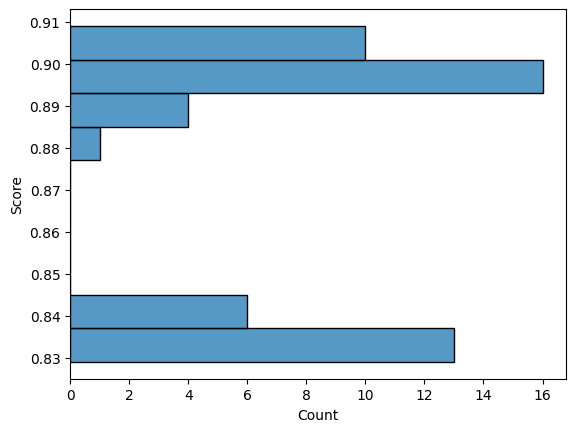

In [ ]:
display(b0)
sns.histplot(data = b0, y = 'Score', bins=10)

### RECRUITMENT

In [ ]:
b1 = performBayes(datasets[1].drop('Target', axis=1), datasets[1]['Target'], 1, param_grid_bayes, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progres

,model__alpha,model__booster,model__colsample_bytree,model__eta,model__gamma,model__lambda,model__max_depth,model__min_child_weight,model__sampling_method,model__subsample,Score
0,0.103268,dart,1.000000,0.076163,0.005361,0.000001,70,1,uniform,0.715530,0.927333
0,0.300332,gbtree,0.021421,0.322509,3.378174,0.000009,2,22,uniform,0.545882,0.936000
0,0.000028,gbtree,0.277010,1.000000,0.000445,88.571163,41,14,uniform,0.318611,0.926000
0,0.000003,gbtree,0.996659,0.274197,0.000074,0.000041,76,2,uniform,0.987088,0.920667
0,0.682942,gbtree,0.006986,0.724846,0.018150,0.000003,57,7,uniform,0.094598,0.820667
0,0.000003,gblinear,0.149937,1.000000,6.962307,0.003056,100,52,uniform,0.976823,0.860667
0,0.000001,dart,0.904218,0.250287,1.018945,0.000980,23,38,uniform,1.000000,0.943333
0,0.001999,gblinear,0.155692,0.025063,0.000150,0.118250,18,96,uniform,0.630006,0.713333
0,0.000049,gblinear,0.895182,0.889701,0.000001,0.000822,90,15,uniform,0.271121,0.857333
0,0.000002,dart,0.130573,1.000000,0.000001,0.000001,1,24,uniform,1.000000,0.936667


<Axes: xlabel='Count', ylabel='Score'>

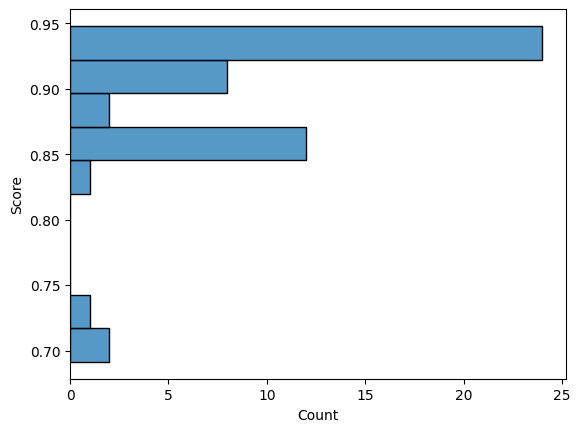

In [ ]:
display(b1)
sns.histplot(data = b1, y = 'Score', bins=10)

### DIABETES

In [ ]:
b2 = performBayes(datasets[2].drop('Target', axis=1), datasets[2]['Target'], 2, param_grid_bayes, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progres

,model__alpha,model__booster,model__colsample_bytree,model__eta,model__gamma,model__lambda,model__max_depth,model__min_child_weight,model__sampling_method,model__subsample,Score
0,0.002303,dart,0.337632,0.081476,2.247962,1.004914,23,1,uniform,0.980489,0.768229
0,0.000275,gblinear,0.318485,0.216639,1.581087,0.001058,16,44,uniform,0.919208,0.769531
0,0.008846,gblinear,0.000000,1.000000,1000.000000,0.000001,100,100,uniform,0.297220,0.773438
0,0.001306,gblinear,0.418321,0.132791,0.254734,0.000022,31,46,uniform,0.041418,0.770833
0,0.000002,gblinear,0.622576,0.138562,92.097999,0.018685,100,10,uniform,0.393262,0.769531
0,0.000074,gblinear,0.896434,0.071940,1000.000000,0.004827,88,100,uniform,0.161963,0.772135
0,0.010343,gblinear,0.098020,0.515847,0.101002,0.000033,40,47,uniform,0.246556,0.772135
0,0.000909,gblinear,0.541268,0.220177,0.000032,0.000023,56,75,uniform,0.447824,0.772135
0,0.006828,gblinear,0.307310,0.003907,0.004227,0.000001,41,77,uniform,0.636207,0.738281
0,0.000122,gblinear,0.713563,0.639003,0.000001,0.009329,37,80,uniform,0.603664,0.772135


<Axes: xlabel='Count', ylabel='Score'>

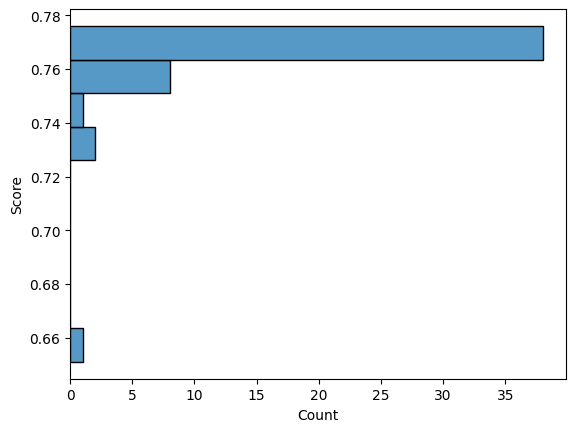

In [ ]:
display(b2)
sns.histplot(data = b2, y = 'Score', bins=10)

### BANKNOTE

In [ ]:
b3 = performBayes(datasets[3].drop('Target', axis=1), datasets[3]['Target'], 3, param_grid_bayes, 50)

Iteration 1 in progress...,
Iteration 2 in progress...,
Iteration 3 in progress...,
Iteration 4 in progress...,
Iteration 5 in progress...,
Iteration 6 in progress...,
Iteration 7 in progress...,
Iteration 8 in progress...,
Iteration 9 in progress...,
Iteration 10 in progress...,
Iteration 11 in progress...,
Iteration 12 in progress...,
Iteration 13 in progress...,
Iteration 14 in progress...,
Iteration 15 in progress...,
Iteration 16 in progress...,
Iteration 17 in progress...,
Iteration 18 in progress...,
Iteration 19 in progress...,
Iteration 20 in progress...,
Iteration 21 in progress...,
Iteration 22 in progress...,
Iteration 23 in progress...,
Iteration 24 in progress...,
Iteration 25 in progress...,
Iteration 26 in progress...,
Iteration 27 in progress...,
Iteration 28 in progress...,
Iteration 29 in progress...,
Iteration 30 in progress...,
Iteration 31 in progress...,
Iteration 32 in progress...,
Iteration 33 in progress...,
Iteration 34 in progress...,
Iteration 35 in progres

,model__alpha,model__booster,model__colsample_bytree,model__eta,model__gamma,model__lambda,model__max_depth,model__min_child_weight,model__sampling_method,model__subsample,Score
0,0.028334,dart,0.513307,0.156859,0.000129,0.000001,61,1,uniform,0.908863,0.996356
0,0.000002,gbtree,0.734504,0.168070,0.000005,0.000001,100,1,uniform,0.769633,0.997084
0,0.000001,gbtree,0.754229,1.000000,0.000001,10.856867,35,1,uniform,1.000000,0.997813
0,0.000001,gbtree,0.000000,0.846417,0.000020,0.000001,13,5,uniform,1.000000,0.986880
0,0.000017,gblinear,0.635145,1.000000,0.000001,0.004577,1,100,uniform,0.624678,0.978863
0,0.000199,gblinear,1.000000,0.396412,0.078263,0.000001,100,93,uniform,1.000000,0.986151
0,0.004320,dart,0.666355,0.124004,0.079889,0.025882,30,1,uniform,0.611067,0.995627
0,0.000001,gblinear,0.098215,1.000000,5.643984,0.000001,1,100,uniform,1.000000,0.989069
0,0.000018,gbtree,0.052005,0.344128,0.004098,0.000053,27,16,uniform,0.837654,0.961374
0,0.000001,gblinear,0.937109,1.000000,1000.000000,0.000044,1,8,uniform,1.000000,0.989796


<Axes: xlabel='Count', ylabel='Score'>

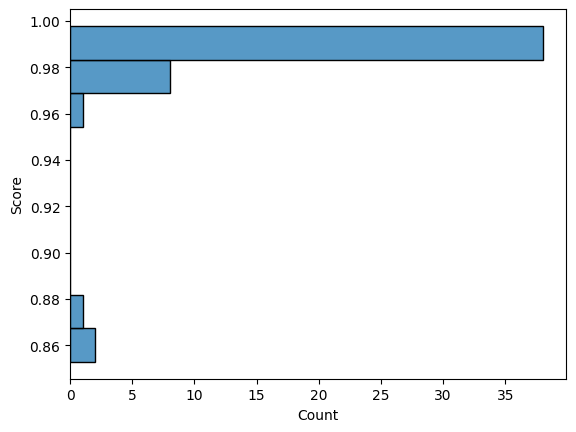

In [ ]:
display(b3)
sns.histplot(data = b3, y = 'Score', bins=10)

## wyniki bayes

In [ ]:
#reset index
b0 = b0.reset_index(drop=True)
b1 = b1.reset_index(drop=True)
b2 = b2.reset_index(drop=True)
b3 = b3.reset_index(drop=True)

best_result_0 = b0.loc[b0['Score'].idxmax()]
best_result_1 = b1.loc[b1['Score'].idxmax()]
best_result_2 = b2.loc[b2['Score'].idxmax()]
best_result_3 = b3.loc[b3['Score'].idxmax()]
best_result_0['Dataset'] = 'car'
best_result_1['Dataset'] = 'recruitment'
best_result_2['Dataset'] = 'diabetes'
best_result_3['Dataset'] = 'banknote'
best_results = pd.concat([best_result_0, best_result_1, best_result_2, best_result_3], axis=1).T

In [ ]:
display(best_results)

,model__alpha,model__booster,model__colsample_bytree,model__eta,model__gamma,model__lambda,model__max_depth,model__min_child_weight,model__sampling_method,model__subsample,Score,Dataset
26,0.000695,dart,0.99568,0.102527,0.012058,0.004361,55,6,uniform,0.735789,0.908996,car
26,0.000001,dart,1.0,0.180736,0.000046,2.410617,31,35,uniform,0.918726,0.948,recruitment
40,0.006204,gblinear,0.838612,0.935702,0.16781,0.000004,87,37,uniform,0.565605,0.776042,diabetes
2,0.000001,gbtree,0.754229,1.0,0.000001,10.856867,35,1,uniform,1.0,0.997813,banknote


In [ ]:
b0['Score'].idxmax()

0

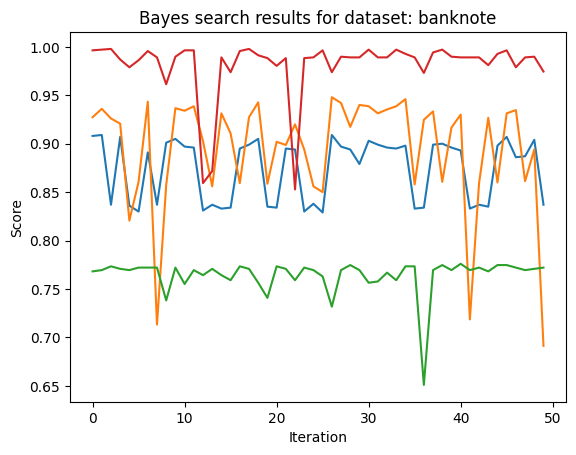

In [ ]:
dataset_names = ['car', 'hiring', 'diabetes', 'banknote']
for i in range(4):
    results = pd.read_csv('./Results/XGBOOST/results_bayes_'+str(i) + '.csv')
    fig = sns.lineplot(data = results, y = 'Score', x=results.index)
    fig.set_title('Bayes search results for dataset: ' + dataset_names[i])
    fig.set_xlabel('Iteration')
    fig.set_ylabel('Score')
    fig.get_figure().show()

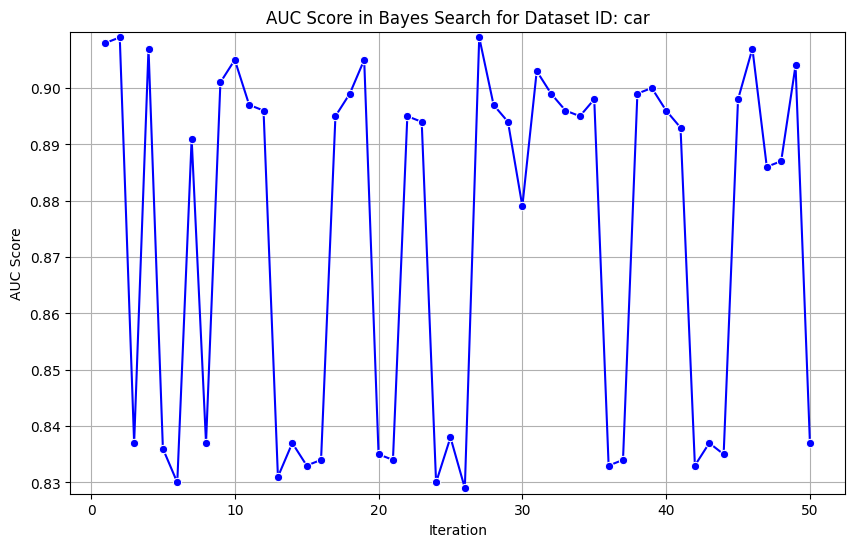

<Figure size 640x480 with 0 Axes>

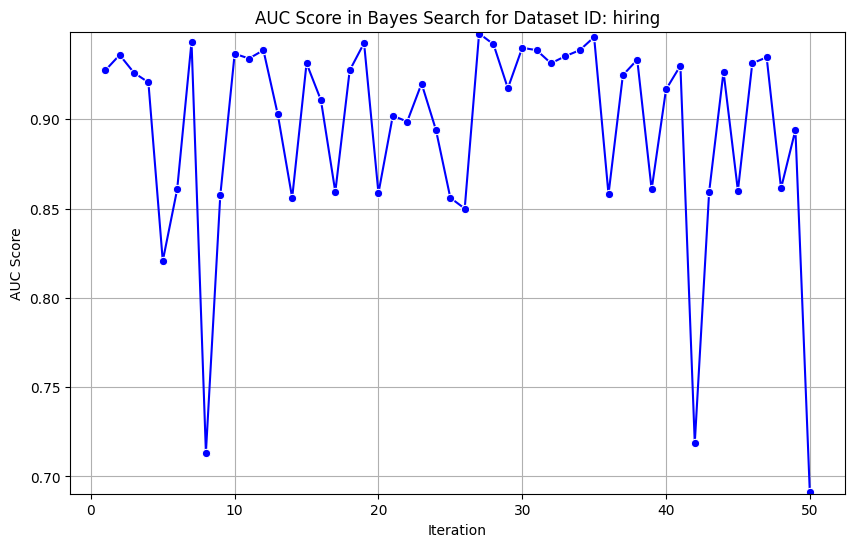

<Figure size 640x480 with 0 Axes>

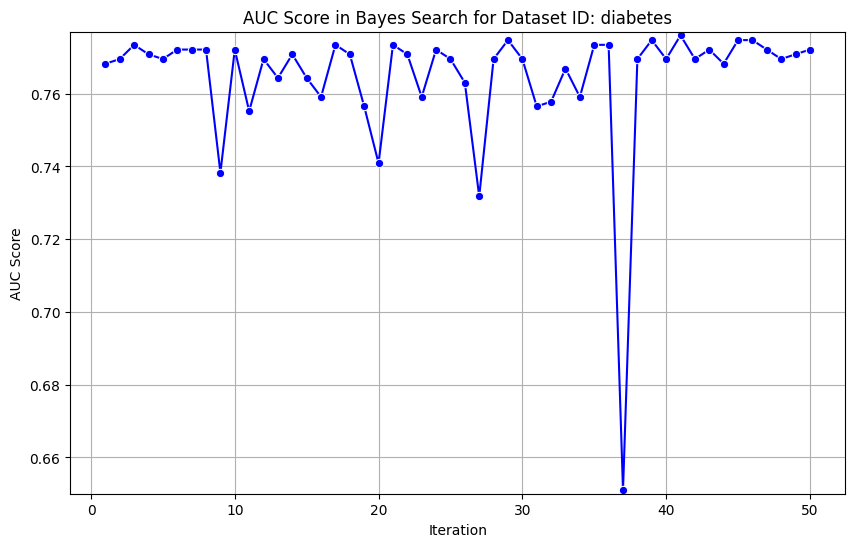

<Figure size 640x480 with 0 Axes>

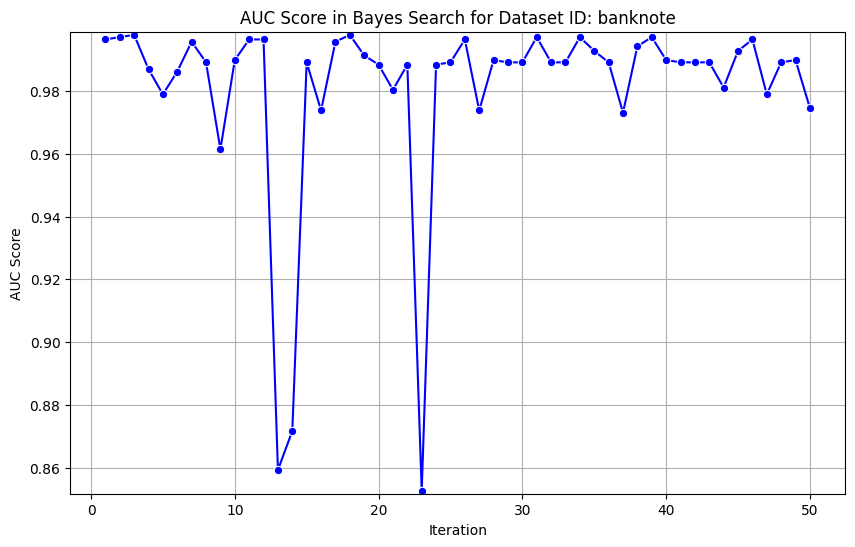

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure(figsize=(10, 6))

    df = pd.read_csv(f'./Results/XGBOOST/results_bayes_{i}.csv')

    sns.lineplot(x=np.linspace(1, 50, 50), y=df['Score'], marker='o', color='blue')

    plt.title(f"AUC Score in Bayes Search for Dataset ID: {dataset_names[i]}")
    plt.xlabel("Iteration")
    plt.ylabel("AUC Score")

    min_score = df['Score'].min()
    max_score = df['Score'].max()
    plt.ylim(min_score - 0.001, max_score + 0.001)

    plt.grid(True)
    plt.show()
    plt.savefig(f'./Results/XGBOOST/bayes_search_{dataset_names[i]}.png')

## ploty do random search

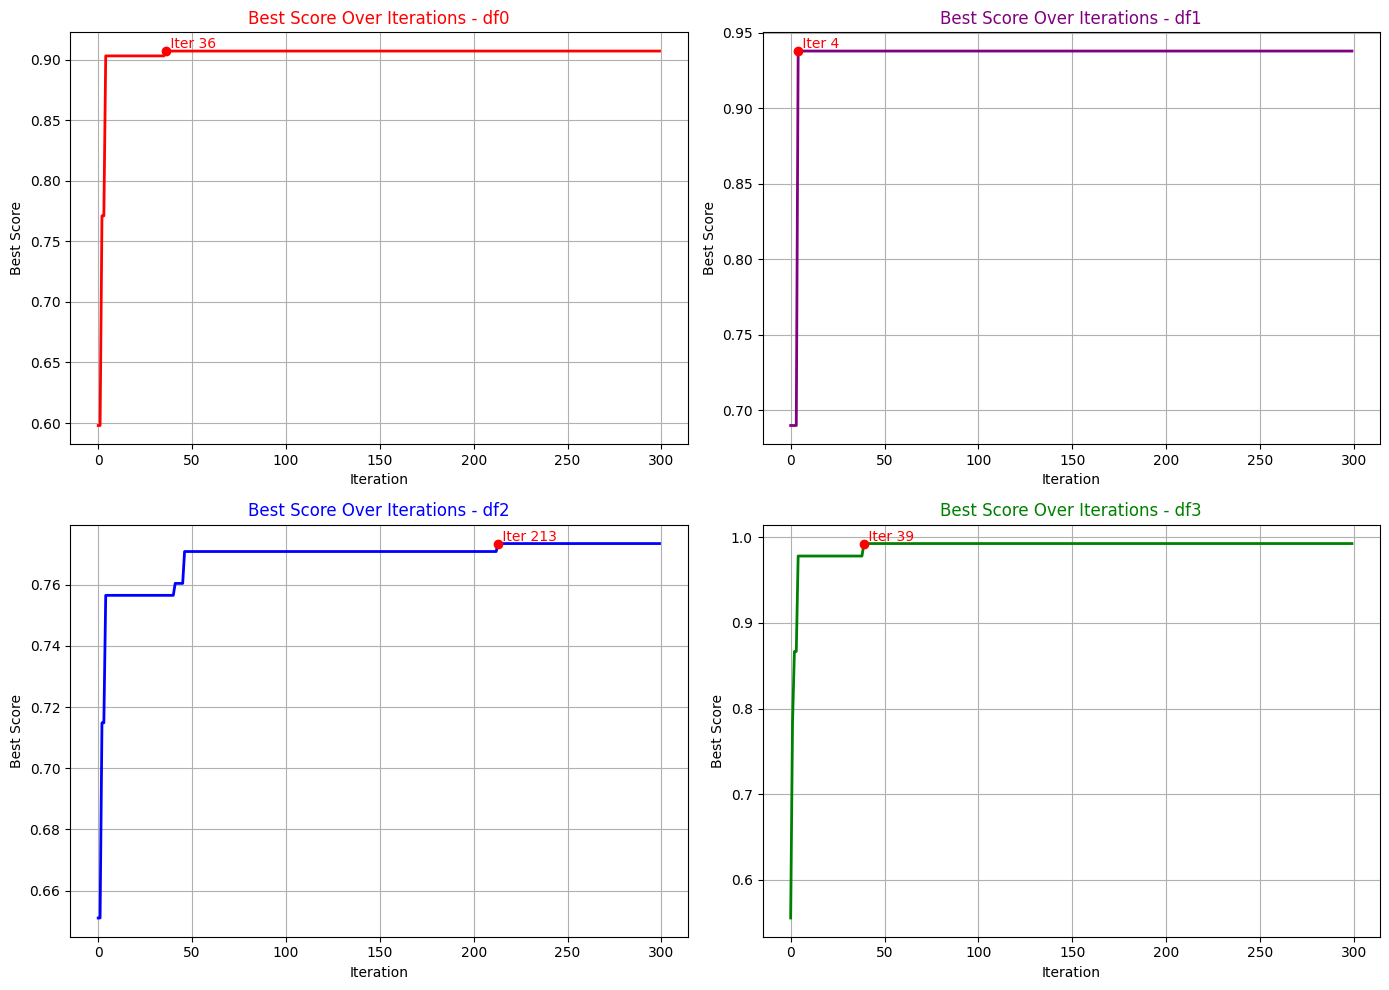

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df0 = pd.read_csv('./Results/XGBOOST/results_0.csv')
df1 = pd.read_csv('./Results/XGBOOST/results_1.csv')
df2 = pd.read_csv('./Results/XGBOOST/results_2.csv')
df3 = pd.read_csv('./Results/XGBOOST/results_3.csv')

# Compute cumulative best scores for each DataFrame
df0['Best_Score_So_Far'] = df0['Score'].cummax()
df1['Best_Score_So_Far'] = df1['Score'].cummax()
df2['Best_Score_So_Far'] = df2['Score'].cummax()
df3['Best_Score_So_Far'] = df3['Score'].cummax()

# Set up a 2x2 grid for subplots without shared y-axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=False)

# Define data, colors, and titles for each plot
dfs = [df0, df1, df2, df3]
colors = ["red", "purple", "blue", "green"]
titles = ['df0', 'df1', 'df2', 'df3']

# Plot each cumulative best score in its respective subplot
for i, (df, color, title) in enumerate(zip(dfs, colors, titles)):
    row, col = divmod(i, 2)

    # Find the iteration where the best score occurred
    best_iteration = df['Best_Score_So_Far'].idxmax()
    best_score = df['Best_Score_So_Far'].max()

    # Plot the cumulative best score
    axs[row, col].plot(df.index, df['Best_Score_So_Far'], color=color, linewidth=2)
    axs[row, col].set_title(f'Best Score Over Iterations - {title}', color=color)
    axs[row, col].set_xlabel('Iteration')
    axs[row, col].set_ylabel('Best Score')
    axs[row, col].grid(True)

    # Mark and label the iteration with the best score
    axs[row, col].plot(best_iteration, best_score, 'ro')  # Red dot
    axs[row, col].text(best_iteration, best_score, f' Iter {best_iteration}',
                       color='red', ha='left', va='bottom', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

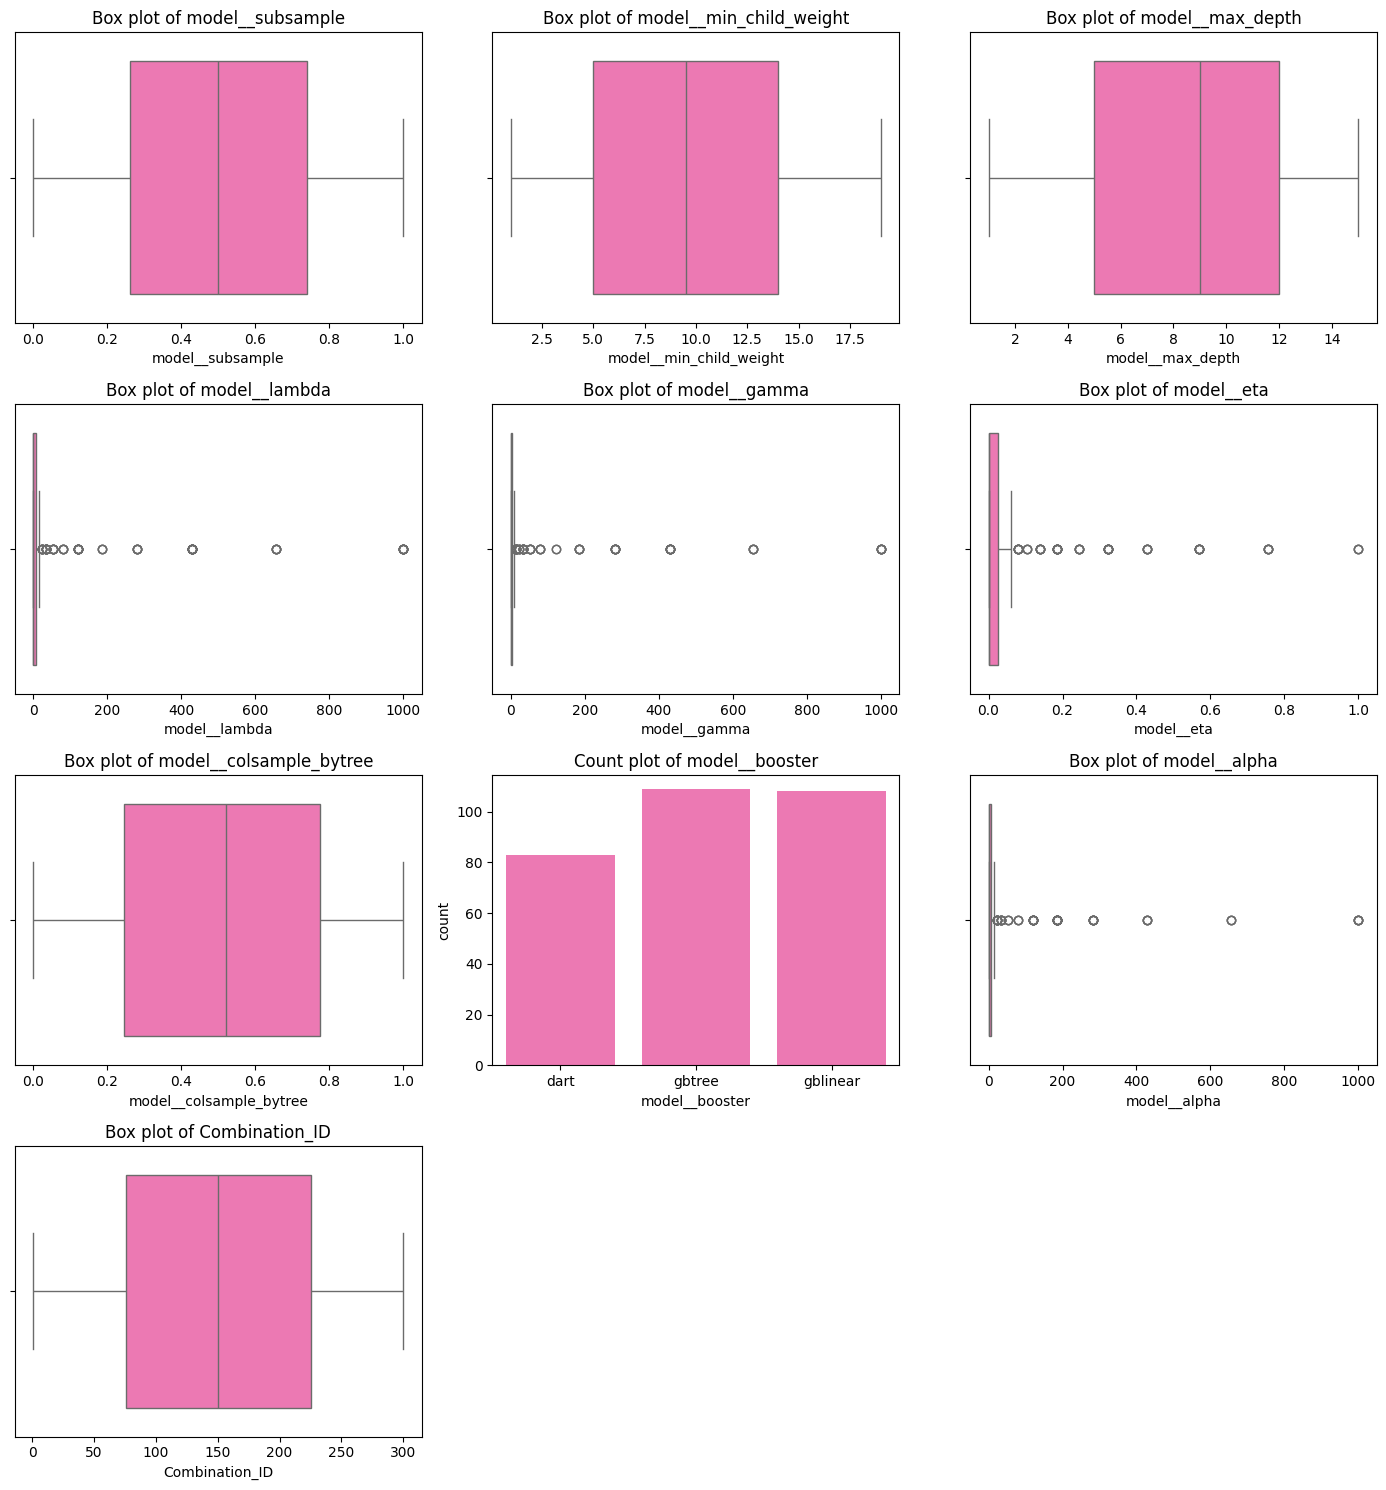

In [ ]:
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  # Load data from CSV
  df0 = pd.read_csv('./Results/XGBOOST/results_0.csv')
  df = df0.drop(columns=['Score', 'model__sampling_method','Dataset' ])  # Drop unnecessary columns

  # Define a custom pink color
  pink_color = "#ff66b3"

  # Determine the number of columns for plotting and set up grid dimensions
  num_cols = len(df.columns)
  num_rows = (num_cols + 1) // 3  # Calculate rows needed for 2 plots per row

  # Set up the figure size
  plt.figure(figsize=(14, 5 * num_rows))  # Adjust height based on number of rows

  # Loop through each column and create a count plot or box plot in the appropriate subplot
  for idx, col in enumerate(df.columns, 1):
      plt.subplot(4, 3, idx)  # Arrange in 2 columns
      if df[col].dtype == 'object' or df[col].nunique() < 10:  # Categorical variable
          sns.countplot(x=col, data=df, color=pink_color)
          plt.title(f'Count plot of {col}')
      else:  # Continuous variable
          sns.boxplot(x=col, data=df, color=pink_color)
          plt.title(f'Box plot of {col}')

  # Adjust layout for better spacing between plots
  plt.tight_layout()
  plt.show()


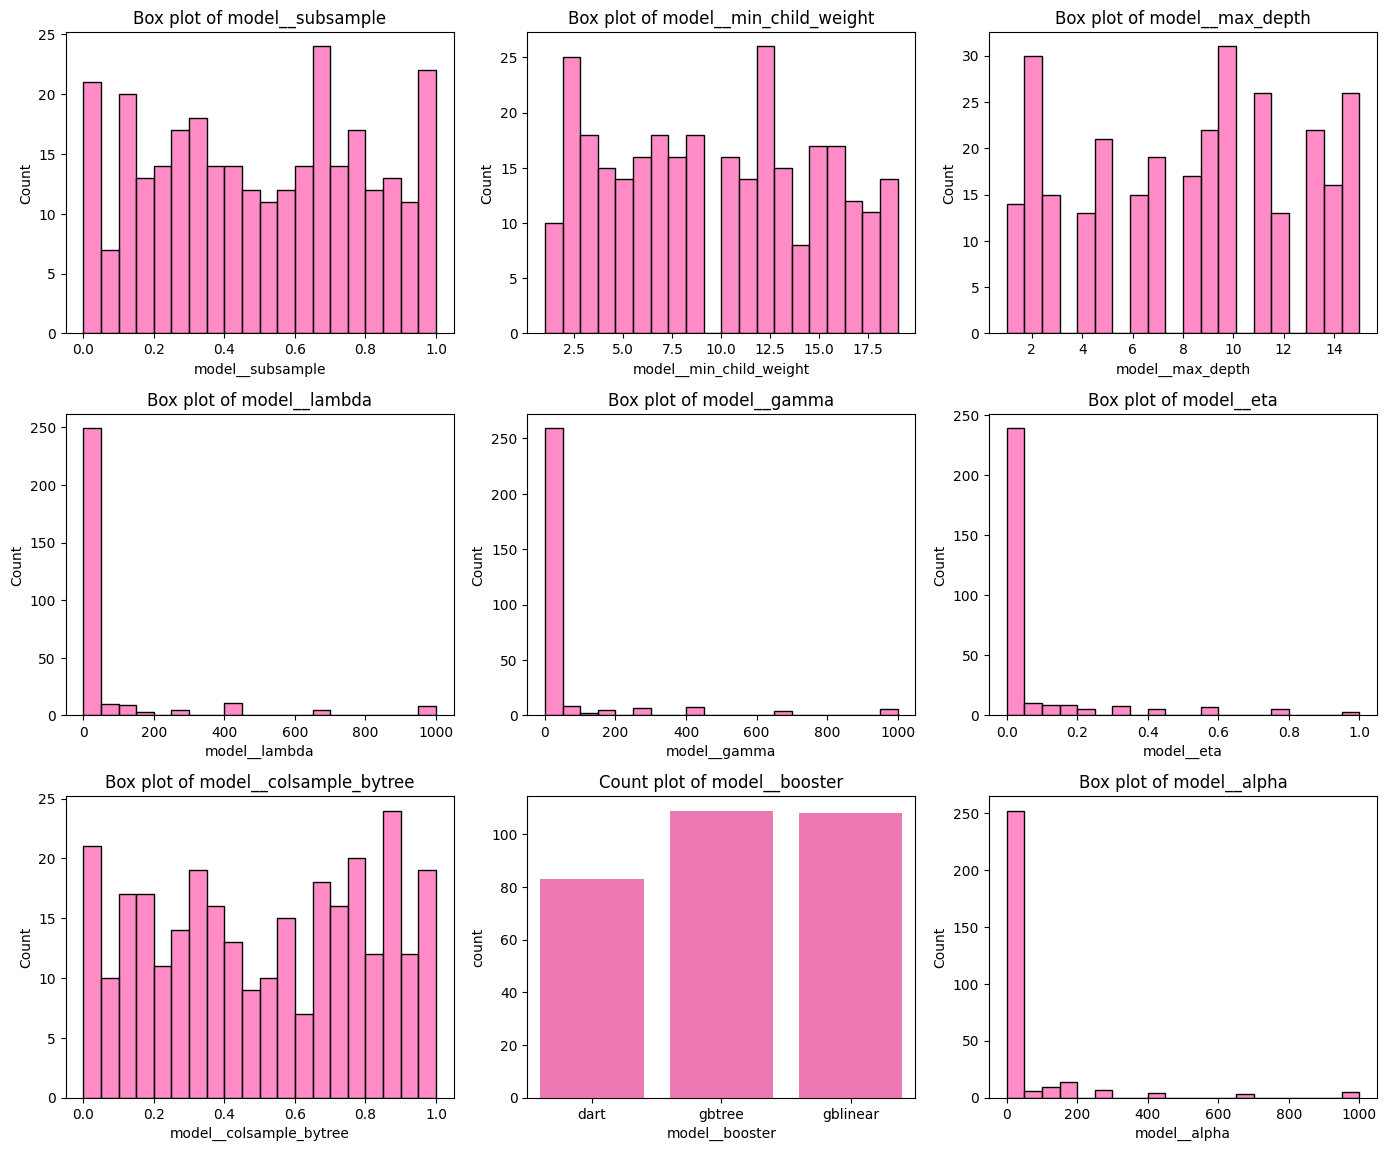

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from CSV
df0 = pd.read_csv('./Results/XGBOOST/results_0.csv')
df = df0.drop(columns=['Score', 'model__sampling_method','Dataset' , 'Combination_ID'])  # Drop unnecessary columns

# Define a custom pink color
pink_color = "#ff66b3"

# Determine the number of columns for plotting and set up grid dimensions
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 3  # Calculate rows needed for 2 plots per row

# Set up the figure size
plt.figure(figsize=(14, 5 * num_rows))  # Adjust height based on number of rows

# Loop through each column and create a count plot or box plot in the appropriate subplot
for idx, col in enumerate(df.columns, 1):
    plt.subplot(4, 3, idx)  # Arrange in 2 columns
    if df[col].dtype == 'object' or df[col].nunique() < 10:  # Categorical variable
        sns.countplot(x=col, data=df, color=pink_color)
        plt.title(f'Count plot of {col}')
    else:  # Continuous variable
        sns.histplot(x=col, data=df, color=pink_color, bins=20)
        plt.title(f'Box plot of {col}')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()
